In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
floats_df = pd.read_csv('/Users/elijahflomen/Desktop/Capstone/data/profileData.csv')
sat_df = pd.read_csv('/Users/elijahflomen/Desktop/Capstone/data/satData.csv')
josie_df = pd.read_csv('/Users/elijahflomen/Desktop/Capstone/data/floatLocData.csv')
merged_df = sat_df.merge(floats_df, on=['float', "cycleNumber", "date"], how='inner')

In [3]:
print(f"Size of sattelite data: {sat_df.shape}")
print(f"Size of float data: {floats_df.shape}")
print(f"Size of merged data: {merged_df.shape}")

Size of sattelite data: (66271, 15)
Size of float data: (37469410, 8)
Size of merged data: (37469410, 20)


In [4]:
# for each float, get min lat, max lat, min long max long -- this will give us a rough idea of the range of motion each float has
max_lat_long = merged_df.groupby(by='float').max().reset_index()[["float", "latitude", "longitude"]].rename(columns={'latitude': 'max_lat', 'longitude': 'max_long'})
min_lat_long = merged_df.groupby(by='float').min().reset_index()[["float", "latitude", "longitude"]].rename(columns={'latitude': 'min_lat', 'longitude': 'min_long'})
float_distances = max_lat_long.merge(min_lat_long, on='float', how='inner')
float_distances

,float,max_lat,max_long,min_lat,min_long
0,1902303,49.236000,-14.494000,41.515000,-18.788000
1,1902304,49.137000,-14.260000,46.579000,-17.493000
2,1902380,18.624000,-36.940000,17.318000,-38.048000
3,1902381,17.346000,-32.990000,15.186000,-34.353000
4,1902382,18.213000,-28.684000,16.645000,-30.500000
...,...,...,...,...,...
564,7900583,-38.797190,165.206910,-39.667270,164.902770
565,7900585,51.468780,-34.579940,49.306480,-39.905310
566,7900588,51.945904,-30.255620,49.401650,-39.023710
567,7900589,57.180080,-45.479260,53.349830,-50.259880


In [5]:
float_distances["lat_dist_km"] = np.abs(float_distances["max_lat"] - float_distances["min_lat"])*110.574
float_distances["long_dist_km"] = np.abs(float_distances["max_long"] - float_distances["min_long"])*110.574
float_distances = float_distances.drop(columns=["max_lat", "max_long", "min_lat", "min_long"])
float_distances["total_dist"] = float_distances["lat_dist_km"] + float_distances["long_dist_km"]
float_distances

,float,lat_dist_km,long_dist_km,total_dist
0,1902303,853.741854,474.804756,1328.546610
1,1902304,282.848292,357.485742,640.334034
2,1902380,144.409644,122.515992,266.925636
3,1902381,238.839840,150.712362,389.552202
4,1902382,173.380032,200.802384,374.182416
...,...,...,...,...
564,7900583,96.208226,33.629976,129.838202
565,7900585,239.094160,588.847462,827.941623
566,7900588,281.328342,969.522784,1250.851125
567,7900589,423.526063,528.612276,952.138339


In [6]:
print("The average float travels ", float_distances['total_dist'].mean(), "km")
print("The max distance traveled by a float is: ",  float_distances['total_dist'].max(), "km")

The average float travels  4235.5599857007355 km
The max distance traveled by a float is:  41904.007632 km


[Text(0.5, 0, 'Distance covered by float')]

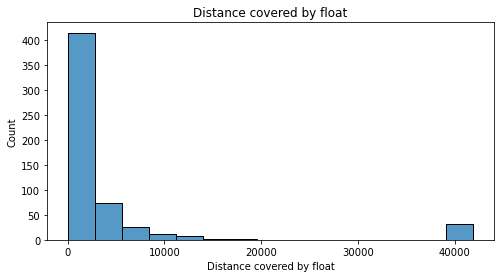

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=float_distances, x='total_dist', bins=15).set_title('Distance covered by float')
ax.set(xlabel='Distance covered by float')


lets see how many floats are associated (on avg) to each sattelite measurement at a given time

In [8]:
float_assoc_check = merged_df.copy()
float_assoc_check = float_assoc_check.groupby(by=["latitude", "longitude", "date"]).nunique()\
    .reset_index()[["latitude", "longitude", "date", "float", "PRES", "CHLA"]]
float_assoc_check.head()

,latitude,longitude,date,float,PRES,CHLA
0,-75.647,-156.978,2017-01-13 13:49:01,1,525,355
1,-75.555,-156.650,2017-01-23 13:55:04,1,527,408
2,-75.364,-156.136,2017-02-02 14:53:42,1,527,328
3,-75.259,-156.559,2017-02-12 14:47:50,1,518,370
4,-75.229,-156.833,2017-02-22 16:29:37,1,528,340


In [9]:
float_measurements_check = merged_df.copy()
print(f"There are {len(list(float_measurements_check.float.unique()))} unique floats in the data")

float_cycles_check = float_measurements_check.groupby(by='float').nunique().reset_index()
avg_cycles_per_float = float_cycles_check["cycleNumber"].mean()
print(f"Each float, on avg, has {avg_cycles_per_float} cycles in the data")

There are 569 unique floats in the data
Each float, on avg, has 116.46924428822496 cycles in the data


[Text(0.5, 0, '# of cycles')]

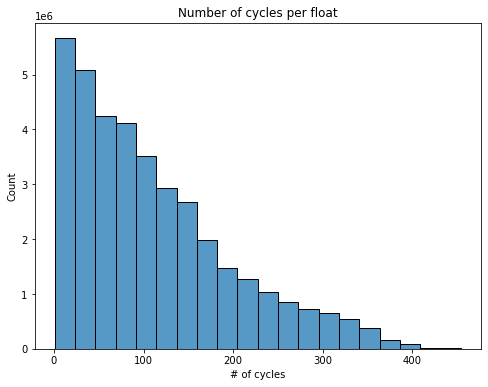

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=float_measurements_check, x='cycleNumber', bins=20).set_title("Number of cycles per float")
ax.set(xlabel='# of cycles')

In [11]:
num_measurements_per_floatcycle = float_measurements_check.groupby(by=['float', "cycleNumber"]).nunique().reset_index()
avg_measurements_per_floatcycle = num_measurements_per_floatcycle["PRES"].mean()

print(f"In a given cycle, a float will collect {avg_measurements_per_floatcycle} data points per cycle")

In a given cycle, a float will collect 565.3967798886391 data points per cycle


However, since floats move around so much, it would be interesting to see how many [float, cycle] measurements we get for a given lat, long

In [12]:
lat_long_measurements_check = merged_df.copy()
lat_long_measurements_check = lat_long_measurements_check.groupby(by=['latitude', 'longitude', 'date']).nunique().reset_index()
lat_long_measurements_check

,latitude,longitude,date,float,cycleNumber,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,PRES,PSAL,TEMP,BBP700,CHLA
0,-75.647,-156.978,2017-01-13 13:49:01,1,1,1,1,1,0,1,1,1,1,1,1,525,286,492,461,355
1,-75.555,-156.650,2017-01-23 13:55:04,1,1,1,1,0,0,1,1,1,1,1,1,527,319,478,444,408
2,-75.364,-156.136,2017-02-02 14:53:42,1,1,1,0,1,1,1,1,1,1,1,1,527,354,502,477,328
3,-75.259,-156.559,2017-02-12 14:47:50,1,1,1,0,1,1,1,1,1,1,1,1,518,368,490,440,370
4,-75.229,-156.833,2017-02-22 16:29:37,1,1,1,0,1,1,1,1,1,1,1,1,528,350,516,402,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66266,78.507,-2.221,2015-06-30 23:59:49,1,1,1,1,1,1,1,1,1,1,1,1,559,397,548,477,213
66267,78.570,1.368,2015-06-05 23:44:39,1,1,1,1,1,1,1,1,1,1,1,1,562,315,532,473,284
66268,78.592,5.477,2015-05-16 23:43:22,1,1,1,1,1,1,1,1,1,1,1,1,562,214,537,525,247
66269,78.718,3.781,2015-05-26 23:44:11,1,1,1,1,1,1,1,1,1,1,1,1,559,391,549,500,287


In [13]:
float_measurements_count_check = merged_df.copy()
float_measurements_count_check = float_measurements_count_check.groupby(by=['float', 'cycleNumber', 'date']).nunique().reset_index()
float_measurements_count_check

,float,cycleNumber,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,PRES,PSAL,TEMP,BBP700,CHLA
0,1902303,1,2021-05-06 02:03:16,1,1,1,1,1,1,1,1,1,1,1,1,523,342,503,492,187
1,1902303,2,2021-05-06 19:32:57,1,1,1,1,1,1,1,1,1,1,1,1,412,274,401,388,211
2,1902303,3,2021-05-07 20:05:38,1,1,1,1,1,1,1,1,1,1,1,1,476,313,470,450,189
3,1902303,4,2021-05-08 22:42:52,1,1,1,1,1,1,1,1,1,1,1,1,512,295,483,474,153
4,1902303,5,2021-05-09 20:29:00,1,1,1,1,1,1,1,1,1,1,1,1,525,330,484,492,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66266,7901001,24,2022-05-03 11:39:00,1,1,1,0,0,0,1,1,1,1,1,1,435,420,431,412,309
66267,7901001,25,2022-05-08 11:38:00,1,1,1,0,0,0,1,1,1,1,1,1,440,432,431,409,249
66268,7901001,26,2022-05-13 11:38:00,1,1,1,0,0,0,1,1,1,1,1,1,436,408,430,407,273
66269,7901001,27,2022-05-18 11:27:00,1,1,1,0,0,0,1,1,1,1,1,1,432,392,428,406,279


In [14]:
print(f"On average, each sattelite measurement is associated with {lat_long_measurements_check.float.mean()} float measurements")

On average, each sattelite measurement is associated with 1.0 float measurements


In [15]:
print(f"On average, each float measurement is associated with {float_measurements_count_check.latitude.mean()} sattelite measurements")

On average, each float measurement is associated with 1.0 sattelite measurements
